In [2]:
import numpy as np
import pandas as pd


msft = pd.read_csv('monthly_MSFT_2.csv')
ibm = pd.read_csv('monthly_IBM.csv')

In [3]:
msft.head()

,timestamp,open,high,low,close,volume
0,2020-11-27,204.29,228.12,200.12,215.23,540260437
1,2020-10-30,213.49,225.21,199.62,202.47,631674298
2,2020-09-30,225.51,232.86,196.25,210.33,768528897
3,2020-08-31,211.52,231.15,203.14,225.53,692382980
4,2020-07-31,203.14,216.38,197.51,205.01,769842002


In [4]:
ibm.head()

,timestamp,open,high,low,close,volume
0,2020-11-27,112.65,125.313,111.16,124.35,97473109
1,2020-10-30,122.36,135.500,105.92,111.66,159130911
2,2020-09-30,122.85,129.950,116.48,121.67,84510174
3,2020-08-31,123.50,130.470,122.15,123.31,74033007
4,2020-07-31,120.27,132.170,115.20,122.94,113972765


In [5]:
msft2 = msft[['timestamp', 'close']].head(32)
ibm2 = ibm[['timestamp', 'close']].head(32)

In [6]:
msft2.set_index('timestamp', inplace=True)
ibm2.set_index('timestamp', inplace=True)

Month=1, Predicted=124.391455, Expected=117.940000
Month=2, Predicted=120.441781, Expected=112.030000
Month=3, Predicted=102.564617, Expected=104.430000
Month=4, Predicted=105.134365, Expected=101.570000
Month=5, Predicted=93.176514, Expected=110.890000
Month=6, Predicted=96.709654, Expected=106.810000
Month=7, Predicted=111.805353, Expected=114.370000
Month=8, Predicted=101.876740, Expected=112.330000
Month=9, Predicted=105.622256, Expected=106.080000
Month=10, Predicted=109.930483, Expected=98.610000
Month=11, Predicted=82.258987, Expected=98.840000
Month=12, Predicted=93.933215, Expected=93.520000
Test RMSE: 9.415


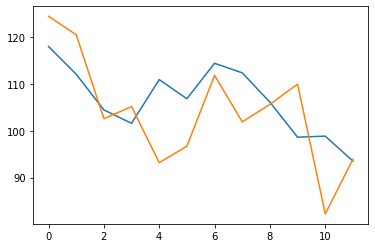

In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
"""
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
"""
import tensorflow as tf
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset, this contain data of microsoft and ibm
# series = df2
series = msft2
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

predicted=126.600995, expected=120.441781
predicted=141.863729, expected=102.564617
predicted=94.436926, expected=105.134365
predicted=97.848097, expected=93.176514
predicted=89.840439, expected=96.709654
predicted=92.070186, expected=111.805353
predicted=123.855491, expected=101.876740
predicted=107.346249, expected=105.622256
predicted=102.673690, expected=109.930483
predicted=115.436590, expected=82.258987
predicted=70.493686, expected=93.933215
[array([120.44178138]), array([102.56461714]), array([105.13436531]), array([93.17651372]), array([96.70965371]), array([111.80535316]), array([101.87674042]), array([105.62225621]), array([109.930483]), array([82.25898724]), array([93.93321492])]
[array([126.60099485]), array([141.8637288]), array([94.43692635]), array([97.84809665]), array([89.84043911]), array([92.07018605]), array([123.85549061]), array([107.34624888]), array([102.67369012]), array([115.43659046]), array([70.49368633])]


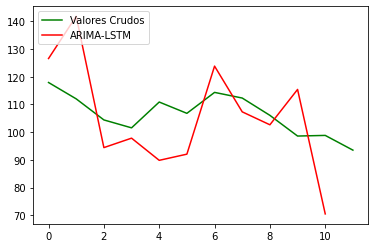

In [9]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 


X = predictions # from LSTM
size = int(len(X) * 0.62)

train, test = X[0:size], X[1:len(X)]

history = [x for x in train]
predictions2 = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions2.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
print(test)
print(predictions2)

# plot
pyplot.plot(raw_values[-12:], color='green')
pyplot.plot(predictions2, color='red')
pyplot.legend(['Valores Crudos','ARIMA-LSTM'], loc='upper left')